# Accurately predicting human essential genes based on deep learning

This section will present a comparative analysis to demonstrate the application and performance of PyTorch models for addressing sequence-based prediction problems.

We'll try to replicate the [DeepHE: Accurately predicting human essential genes based on deep learning](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008229) deep learning model and evaluate its performance. Other models will be compared to the DeepHE model.

DeepHE's model is based on the multilayer perceptron structure. It includes one input layer, three hidden layers, and one output layer. All the hidden layers utilize the ReLU activation function. The output layer uses sigmoid activation function to perform discrete classification. The loss function in DeepHE is binary cross-entropy. A dropout layer is used after each hidden layer.

In [13]:
%load_ext autoreload
import pandas as pd
from os.path import exists
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


At this point, there is already 2 cleaned datasets which will be used in this notebook.
- `deg.csv`: 16 datasets grouped that contain essential genes of the human genome. Each sequence has an EMBL id associated, the original dataset it came from, among other information. [Link](http://origin.tubic.org/deg/public/index.php)
- `negative.csv`: contains the genome DNA sequences of humans for all annotated genes from Ensembl. Each sequence has an EMBL id associated. [Link](http://www.ensembl.org/Homo_sapiens/Info/Index)

The process of cleaning each dataset is described below:
- `deg.csv`:
    - removed rows with unavailable sequences.
- `negative.csv`:
    - removed all rows which sequences belonged to the `deg.csv` dataset.
    - removed all rows which EMBL id was in the `deg.csv` dataset.
    - grouped all sequences with the same EMBL id, and kept only the first two.

One of the tasks in this notebook is to also build the positive dataset (`essential_genes_positve.csv`), which will contain only the sequences that are in at least 5 different datasets.

In [14]:
deg_dataset = pd.read_csv("datasets/essential_genes/deg.csv", sep=';')
print(deg_dataset.shape)

eg_negative = pd.read_csv("datasets/essential_genes/negative.csv", sep=',')
print(eg_negative.shape)

(26791, 15)
(27684, 2)


Creating positive essential genes dataset. Each sequence needs to be in at least 5 datasets.

In [16]:
# for each sequence, get all the datasets that contain it
d = {}
for _, row in deg_dataset.iterrows():
    if(row["sequence"] in d):
        d[row["sequence"]].append((row["id1"], row["id4"]))
    else:
        d[row["sequence"]] = [(row["id1"], row["id4"])]


# get a list of sequences that are in more than 5 datasets
essential_sequences = []
for key, val in d.items():
    if(len(val) >= 5):
        essential_sequences.append((val[0][1], key))
        
# create dataframe with essential sequences
eg_positive = pd.DataFrame(essential_sequences, columns=["id", "sequence"])
print(eg_positive.head())
print(eg_positive.shape)

# write to csv
eg_positive.to_csv("datasets/essential_genes/positive.csv", index=False)

     id                                           sequence
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...
(2010, 2)


In [17]:
print("unique positive sequences:", len(set(eg_positive["sequence"])))
print("unique negative sequences:", len(set(eg_negative["sequence"])))

unique positive sequences: 2010
unique negative sequences: 23443


Even though the negative dataset has 27684 sequences, not all of them are unique. So, we need to remove the duplicates.

In [18]:
eg_negative = eg_negative.drop_duplicates(subset="sequence")
print(eg_negative.shape)
eg_negative.to_csv("datasets/essential_genes/negative_unique.csv", index=False)

(23443, 2)


At this point, we have both positive and negative datasets:
* eg_positive (2010,  2) -> positive dataset with essential genes 
* eg_negative (23443, 2) -> negative dataset with non essential genes 

Joining the positive and negative datasets

In [19]:
# adding labels to the dataset
eg_positive["label"] = 1
eg_negative["label"] = 0

# joining the two datasets
dataset = pd.concat([eg_positive, eg_negative])

print(dataset.shape)
print(dataset.head())

dataset.to_csv("datasets/essential_genes/dataset.csv", index=False)

(25453, 3)
     id                                           sequence  label
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...      1
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...      1
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...      1
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...      1
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...      1


In [20]:
print(dataset.shape)

(25453, 3)


<AxesSubplot:xlabel='label'>

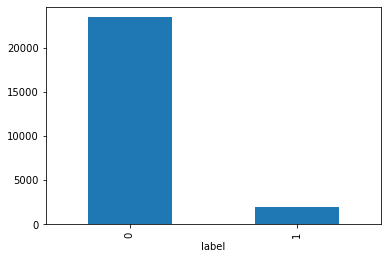

In [21]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

## Classification using DNA descriptors

In [22]:
%load_ext autoreload
%autoreload 2
import sys
import torch
from torch import nn
import os

sys.path.append('../')
from descriptors.descriptors import DNADescriptor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors()
        res.update(feature)
        list_feature.append(res)
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df

Skip the calculation of descriptors if `features.pkl` exists which already has them calculated. Skip all of this if `fps_x_descriptor.pkl` exists because it already has the features calculated and **normalized**. The need of data normalization is explained in the next section.

In [24]:
if exists("datasets/essential_genes/fps_x_descriptor.pkl") == False:
    if exists("datasets/essential_genes/features.pkl"):
        with open("datasets/essential_genes/features.pkl", "rb") as f:
            features = pickle.load(f)
        print("Features loaded from pickle file")
    else:
        features = calculate_feature(dataset)
        with open("datasets/essential_genes/features.pkl", "wb") as f:
            pickle.dump(features, f)
else:
    print("Features already calculated and normalized")

Features already calculated and normalized


Functions to help normalize the data.

Without being normalized, we have a dataset with 17 columns. Each column is a result of a DNA descriptor, and some of these columns are numbers, dicts and even lists.

We still need to normalize those who have dictionaries and lists because the model can't handle data in these types.

To normalize the data, dicts and lists need to "explode" into more columns. 

E.g. dicts:

| descriptor_hello |
| ---------------- |
| {'a': 1, 'b': 2} |

will be transformed into:

| descriptor_hello_a | descriptor_hello_b |
| ------------------ | ------------------ |
| 1                  | 2                  |

E.g. lists:

| descriptor_hello |
| ---------------- |
| [1, 2, 3]        |

will be transformed into:

| descriptor_hello_0 | descriptor_hello_1 | descriptor_hello_2 |
| ------------------ | ------------------ | ------------------ |
| 1                  | 2                  | 3                  |

In [25]:
def process_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    fps_x.drop(field, axis=1, inplace=True)
    return new_df

def process_lists_of_lists(fps_x, field):
    l = fps_x[field].to_list()
    new_df = pd.DataFrame(l)
    new_df.columns = [str(field) + "_" + str(i) for i in new_df.columns]
    empty_val = {} if field == "enhanced_nucleic_acid_composition" else []
    small_processed = []
    for f in new_df.columns:
        col = [empty_val if i is None else i for i in new_df[f].to_list()]
        sub = pd.DataFrame(col)
        sub.columns = [str(f) + "_" + str(i) for i in sub.columns]
        small_processed.append(sub)
    fps_x.drop(field, axis=1, inplace=True)
    return small_processed

In [26]:
def normalize_features():
    fps_y = dataset['label']
    fps_x = features.loc[:, features.columns != 'label']
    fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
    print(fps_x.shape)
    
    lists = ["nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC", "DAC", "DCC", "DACC", "TAC","TCC","TACC"]
    lists_of_lists = [
        "accumulated_nucleotide_frequency"
    ]

    small_processed = []
    for i in lists:
        new_df = process_lists(fps_x, i)
        small_processed.append(new_df)
        
    for i in lists_of_lists:
        smaller_processed = process_lists_of_lists(fps_x, i)
        small_processed += smaller_processed

    # concat final with original
    fps_x = pd.concat([fps_x, *small_processed], axis=1)

    with open("datasets/essential_genes/fps_x_descriptor.pkl", "wb") as f:
        pickle.dump(fps_x, f)
        
    with open("datasets/essential_genes/fps_y_descriptor.pkl", "wb") as f:
        pickle.dump(fps_y, f)
    
    return fps_x, fps_y

Skip the data normalization if it was already performed (`fps_x_descriptor.pkl` exists).

In [27]:
if exists("datasets/essential_genes/fps_x_descriptor.pkl"):
    with open("datasets/essential_genes/fps_x_descriptor.pkl", "rb") as f:
        fps_x = pickle.load(f)
    with open("datasets/essential_genes/fps_y_descriptor.pkl", "rb") as f:
        fps_y = pickle.load(f)
    print("Features loaded from pickle file")
else:
    fps_x, fps_y = normalize_features()
fps_x

Features loaded from pickle file


,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,dinucleotide_composition_AA,dinucleotide_composition_AC,dinucleotide_composition_AG,...,accumulated_nucleotide_frequency_0_G,accumulated_nucleotide_frequency_0_T,accumulated_nucleotide_frequency_1_A,accumulated_nucleotide_frequency_1_C,accumulated_nucleotide_frequency_1_G,accumulated_nucleotide_frequency_1_T,accumulated_nucleotide_frequency_2_A,accumulated_nucleotide_frequency_2_C,accumulated_nucleotide_frequency_2_G,accumulated_nucleotide_frequency_2_T
0,1233,0.440,0.560,0.303,0.193,0.247,0.256,0.096,0.052,0.075,...,0.224,0.247,0.324,0.182,0.227,0.267,0.321,0.188,0.240,0.251
1,8532,0.412,0.588,0.344,0.208,0.205,0.244,0.126,0.054,0.089,...,0.240,0.250,0.336,0.193,0.220,0.251,0.345,0.198,0.211,0.246
2,3720,0.604,0.396,0.215,0.290,0.314,0.181,0.041,0.050,0.089,...,0.340,0.153,0.205,0.311,0.322,0.162,0.208,0.303,0.319,0.171
3,1530,0.414,0.586,0.303,0.169,0.246,0.282,0.099,0.044,0.080,...,0.248,0.290,0.298,0.163,0.247,0.292,0.301,0.164,0.244,0.291
4,963,0.559,0.441,0.212,0.286,0.273,0.229,0.048,0.045,0.076,...,0.282,0.224,0.199,0.286,0.278,0.237,0.213,0.289,0.267,0.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25444,576,0.439,0.561,0.288,0.210,0.229,0.273,0.089,0.068,0.068,...,0.229,0.312,0.292,0.181,0.215,0.312,0.296,0.206,0.208,0.289
25445,576,0.434,0.566,0.286,0.212,0.222,0.280,0.089,0.068,0.066,...,0.229,0.312,0.292,0.181,0.215,0.312,0.296,0.206,0.208,0.289
25446,3363,0.394,0.606,0.338,0.192,0.202,0.268,0.122,0.055,0.076,...,0.193,0.262,0.353,0.190,0.196,0.262,0.351,0.187,0.198,0.264
25447,1101,0.633,0.367,0.227,0.292,0.341,0.140,0.037,0.056,0.105,...,0.295,0.175,0.227,0.292,0.323,0.158,0.225,0.293,0.340,0.142


In [28]:
from src import hyperparameter_tuning
from ray import tune

Training the model and evaluating the performance

In [29]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_vals = {
    'epochs': 50,
    'optimizer_label': 'adam',
    'loss_function': nn.CrossEntropyLoss(),
    'patience': 2, 
    'output_size': 2,
    'model_label': 'mlp',
    'data_dir': 'essential_genes',
    'mode': 'descriptor'
}

# these are hyperparameters to be tuned
config = {
    "hidden_size": tune.choice([32, 64, 128, 256]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32]),
    "dropout": tune.uniform(0.3, 0.5)
}

In [30]:
hyperparameter_tuning(device, fixed_vals, config)

/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)
2022-06-22 17:16:25,583	WARNING experiment.py:295 -- No name detected on trainable. Using DEFAULT.
2022-06-22 17:16:25,584	INFO registry.py:66 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 131.9/754.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/80 CPUs, 2.0/2 GPUs, 0.0/437.51 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06-22_17-16-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+-----------+---------------+-------------+
| Trial name          | status   | loc   |   batch_size |   dropout |   hidden_size |          lr |
|---------------------+----------+-------+--------------+-----------+---------------+-------------|
| DEFAULT_aa136_00000 | RUNNING  |       |           32 |  0.490806 |           128 | 0.000464116 |
| DEFAULT_aa136_00001 | PENDING  |       |           32 |  0.363243 |            64 | 0.000837212 |
| DEFAULT_aa136_00002 | PENDING  |       |         

2022-06-22 17:19:34,674	INFO tune.py:561 -- Total run time: 189.09 seconds (188.86 seconds for the tuning loop).


Result for DEFAULT_aa136_00009:
  accuracy: 0.8713163064833006
  date: 2022-06-22_17-19-34
  done: true
  experiment_id: a9607a16f4c6490a9866e7f0151be9ec
  hostname: turing
  iterations_since_restore: 2
  loss: 0.5211453443410629
  mcc: 0.1769352913273523
  node_ip: 192.168.85.234
  pid: 2207967
  should_checkpoint: true
  time_since_restore: 4.441319465637207
  time_this_iter_s: 1.9433724880218506
  time_total_s: 4.441319465637207
  timestamp: 1655914774
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: aa136_00009
  
== Status ==
Memory usage on this node: 133.2/754.3 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 32.000: None | Iter 16.000: -0.5176659166812897 | Iter 8.000: -0.5056363753475881 | Iter 4.000: -0.5169517792761326 | Iter 2.000: -0.5160677171015478 | Iter 1.000: -0.5282449847087264
Resources requested: 0/80 CPUs, 0/2 GPUs, 0.0/437.51 GiB heap, 0.0/186.26 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jabreu/ray_results/DEFAULT_2022-06